In [258]:
import typing as t
import random

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
from tqdm import tqdm

In [259]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [260]:
torch.set_warn_always(True)

sns.set_theme()
plt.rcParams["figure.figsize"] = (3.5, 2.5)

## Вспомогательные функции

In [261]:
SignT = t.Literal[-1, 1]  # 1 - max, -1 - min
FuncT = t.Callable[[torch.Tensor], torch.Tensor]


def sign_func(func: FuncT, sign: SignT) -> FuncT:
    return lambda x: -sign * func(x)


def save_animation(xs: list[torch.Tensor], path: str, limit: int = 500, delay: int = 30) -> None:
    xs_ = xs.copy()
    delayed = xs_[-1]
    if len(xs_) > limit:
        xs_ = xs_[::len(xs_) // limit]
    for i in range(delay):
        xs_.append(delayed)

    with tqdm(total=len(xs_) + 1) as pbar:
        def animate(i):
            scatter.set_data(xs_[i].detach(), f(xs_[i]).detach())
            pbar.update()

        fig, ax = plt.subplots(1, 1)
        ax.plot(X.detach(), Y.detach())
        scatter, = ax.plot([], [], marker="o", color="r")
        anim = animation.FuncAnimation(fig, animate, interval=1, frames=len(xs_))
        anim.save(path, writer="pillow", fps=20)
        plt.close()


def answer(x: torch.Tensor, sign: SignT, reason: str) -> None:
    extrema = "минимум" if sign == -1 else "максимум"
    if torch.isnan(x):
        print(f"Локальный {extrema} не найден")
    else:
        x, y = x.item(), f(x).item()
        print(f"Найден локальный {extrema}: {x=:5f}, f(x)={y:5f}")
        plt.plot(X.detach(), Y.detach())
        plt.scatter(x, y, color="r")
    print(f"Причина остановки: {reason}")

## Методы оптимизации

In [292]:
def gradient_descent(
        func: FuncT,
        interval: t.Tuple[float, float],
        sign: SignT,
        eps: float,
        lr: float,
        initial_state: float = None,
) -> tuple[torch.Tensor, list[torch.Tensor], str]:
    """Градиентный спуск"""
    sign_f = sign_func(func, sign)
    start, end = interval
    if initial_state is None:
        initial_state = random.uniform(start, end)
    elif initial_state < start or initial_state > end:
        return torch.tensor(torch.nan), [torch.tensor(torch.nan)], "initial_state вне интервала"

    interval_eps = lr * (end - start)  # наивное расширение границ интервала
    adj_start, adj_end = start - interval_eps, end + interval_eps

    x = torch.tensor(initial_state, dtype=torch.float, requires_grad=True)
    if torch.isnan(sign_f(x)):
        return torch.tensor(torch.nan), [torch.tensor(torch.nan)], f"f(initial_state={initial_state:.4f}) не определена"

    i, n = 0, 1000
    with tqdm() as pbar:
        xs = []
        while True:
            xs.append(x.detach().clone())  # выполнится минимум 2 раза

            if x < adj_start or x > adj_end:  # вышли за границу дальше дозволенного
                # искомый экстремум - предыдущая позиция или одна из границ
                start_t, end_t = torch.tensor(start), torch.tensor(end)
                if start <= xs[-2] <= end:
                    _, x = min((sign_f(xs[-2]), xs[-2]), (sign_f(start_t), start_t), (sign_f(end_t), end_t))
                else:
                    _, x = min((sign_f(start_t), start_t), (sign_f(end_t), end_t))
                xs.append(x.detach().clone())
                return xs[-1], xs, "выход за границы интервала"

            y = sign_f(x)
            if torch.isnan(y):
                xs.pop()
                return xs[-1], xs, f"функция для следующего x={x.item():.4f} не определена"

            # а эти 3 строчки про "возможности по автоматическому дифференцированию, которые предоставляет PyTorch"
            y.backward()
            grad = x.grad.clone()
            x.grad.zero_()

            with torch.no_grad():
                x -= lr * grad  # ладно, это 4-ая
                if torch.abs(x - xs[-1]) <= eps:  # найден экстремум с необходимой точностью
                    xs.append(x.detach().clone())
                    return xs[-1], xs, "найден экстремум"

            if i % n == 0:
                pbar.update(n)
            i += 1


def thnx_optimizer(
        get_optimizer: t.Callable[[torch.Tensor], optim.Optimizer],
        func: FuncT,
        interval: t.Tuple[float, float],
        sign: SignT,
        eps: float,
        initial_state: float = None,
) -> tuple[torch.Tensor, list[torch.Tensor], str]:
    """Произвольный оптимизатор"""
    sign_f = sign_func(func, sign)
    start, end = interval
    if initial_state is None:
        initial_state = random.uniform(start, end)
    elif initial_state < start or initial_state > end:
        return torch.tensor(torch.nan), [torch.tensor(torch.nan)], "initial_state вне интервала"

    x = torch.tensor(initial_state, dtype=torch.float, requires_grad=True)
    if torch.isnan(sign_f(x)):
        return torch.tensor(torch.nan), [torch.tensor(torch.nan)], f"f(initial_state={initial_state:.4f}) не определена"

    optimizer = get_optimizer(x)
    lr = optimizer.param_groups[0]["lr"]

    interval_eps = lr * (end - start)  # наивное расширение границ интервала
    adj_start, adj_end = start - interval_eps, end + interval_eps

    i, n = 0, 1000
    with tqdm() as pbar:
        xs = []
        while True:
            xs.append(x.detach().clone())  # выполнится минимум 2 раза

            if x < adj_start or x > adj_end:  # вышли за границу дальше дозволенного
                # искомый экстремум - предыдущая позиция или одна из границ
                start_t, end_t = torch.tensor(start), torch.tensor(end)
                if start <= xs[-2] <= end:
                    _, x = min((sign_f(xs[-2]), xs[-2]), (sign_f(start_t), start_t), (sign_f(end_t), end_t))
                else:
                    _, x = min((sign_f(start_t), start_t), (sign_f(end_t), end_t))
                xs.append(x.detach().clone())
                return xs[-1], xs, "выход за границы интервала"

            y = sign_f(x)
            if torch.isnan(y):
                xs.pop()
                return xs[-1], xs, f"функция для следующего x={x.item():.4f} не определена"

            # здесь точно 3 строчки
            optimizer.zero_grad()
            y.backward()
            optimizer.step()

            if torch.abs(x - xs[-1]) <= eps:  # найден экстремум с необходимой точностью
                xs.append(x.detach().clone())
                return xs[-1], xs, "найден экстремум"

            if i % n == 0:
                pbar.update(n)
            i += 1

## Шаблон: градиентный спуск

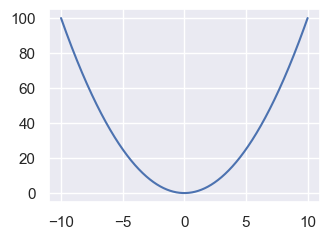

In [293]:
def f(x: torch.Tensor) -> torch.Tensor:
    return x ** 2


SIGN = -1  # 1 - max, -1 - min

START, END = -10, 10
EPS = 0.0000001
LR = 0.05

X = torch.arange(START, END + 0.001, 0.001)
Y = f(X)
plt.plot(X.detach(), Y.detach());

1000it [00:00, 39422.00it/s]


Найден локальный минимум: x=-0.000001, f(x)=0.000000
Причина остановки: найден экстремум


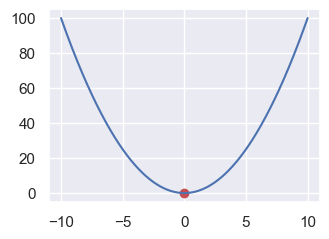

In [294]:
x, xs, reason = gradient_descent(func=f, interval=(START, END), sign=SIGN, eps=EPS, lr=LR, initial_state=-10)
answer(x, SIGN, reason)

In [295]:
save_animation(xs, "template_1.gif", delay=10)

100%|██████████| 166/166 [00:08<00:00, 20.35it/s]


![](template_1.gif)

## Шаблон: произвольный оптимизатор

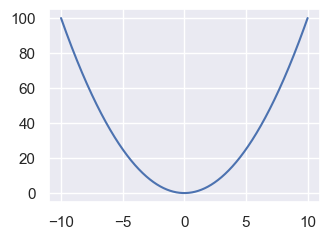

In [296]:
def f(x: torch.Tensor) -> torch.Tensor:
    return x ** 2


SIGN = -1  # 1 - max, -1 - min

START, END = -10, 10
EPS = 0.0000001
LR = 0.05

X = torch.arange(START, END + 0.001, 0.001)
Y = f(X)
plt.plot(X.detach(), Y.detach());

1000it [00:00, 3904.05it/s]


Найден локальный минимум: x=-0.000003, f(x)=0.000000
Причина остановки: найден экстремум


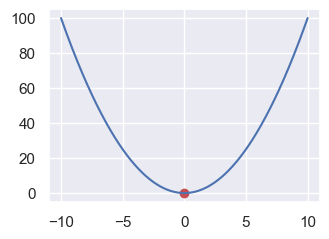

In [297]:
x, xs, reason = thnx_optimizer(
    get_optimizer=lambda x: optim.Adam([x], lr=LR),
    func=f,
    interval=(START, END),
    sign=SIGN,
    eps=EPS,
    initial_state=-10,
)
answer(x, SIGN, reason)

In [298]:
save_animation(xs, "template_2.gif", limit=400, delay=10)

100%|██████████| 479/479 [00:20<00:00, 22.94it/s]


![](template_2.gif)

## Билеты

### Билет №1

При помощи возможностей по автоматическому дифференцированию, которые предоставляет библиотека PyTorch, найдите минимум функции $ y=ln(x^2+10x+10) $ на отрезке \[-10, 10]. Реализуйте процесс поиска экстремума таким образом, чтобы при нахождении точки экстремума процедура поиска останавливалась. Продемонстрируйте процесс оптимизации. Изобразите график функции y(x) на заданном отрезке.

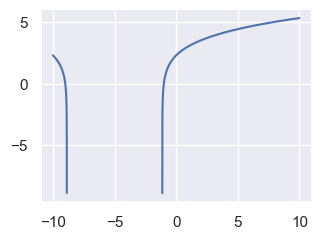

In [301]:
def f(x: torch.Tensor) -> torch.Tensor:
    return torch.log(x ** 2 + 10 * x + 10)


SIGN = -1  # 1 - max, -1 - min

START, END = -10, 10
EPS = 0.0000001
LR = 0.00005

X = torch.arange(START, END + 0.001, 0.001)
Y = f(X)
plt.plot(X.detach(), Y.detach());

72000it [00:15, 4571.75it/s]


Найден локальный минимум: x=-1.122556, f(x)=-3.364694
Причина остановки: функция для следующего x=-1.1338 не определена


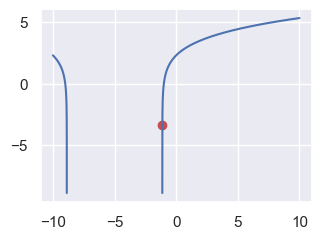

In [302]:
x, xs, reason = gradient_descent(func=f, interval=(START, END), sign=SIGN, eps=EPS, lr=LR, initial_state=1.8)
answer(x, SIGN, reason)

In [303]:
save_animation(xs, "optimization_1.gif")

100%|██████████| 513/513 [00:20<00:00, 25.23it/s]


![](optimization_1.gif)

### Билет №2

При помощи возможностей по автоматическому дифференцированию, которые предоставляет библиотека PyTorch, найдите минимум функции $ y=x-5 ln(2x-1)+2 $ на отрезке \[-10, 10]. Реализуйте процесс поиска экстремума таким образом, чтобы при нахождении точки экстремума процедура поиска останавливалась. Продемонстрируйте процесс оптимизации. Изобразите график функции y(x) на заданном отрезке.

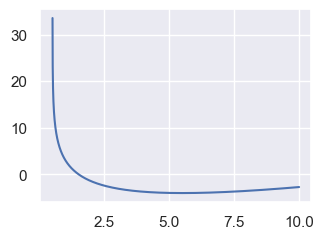

In [304]:
def f(x: torch.Tensor) -> torch.Tensor:
    return x - 5 * torch.log(2 * x - 1) + 2


SIGN = -1  # 1 - max, -1 - min

START, END = -10, 10
EPS = 0.000001
LR = 0.001

X = torch.arange(START, END + 0.001, 0.001)
Y = f(X)
plt.plot(X.detach(), Y.detach());

29000it [00:06, 4548.91it/s]


Найден локальный минимум: x=5.494049, f(x)=-4.012922
Причина остановки: найден экстремум


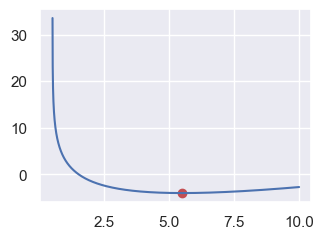

In [305]:
x, xs, reason = gradient_descent(func=f, interval=(START, END), sign=SIGN, eps=EPS, lr=LR, initial_state=0.6)
answer(x, SIGN, reason)

In [306]:
save_animation(xs, "optimization_2.gif")

100%|██████████| 534/534 [00:20<00:00, 26.29it/s]


![](optimization_2.gif)

### Билет №3

При помощи возможностей по автоматическому дифференцированию, которые предоставляет библиотека PyTorch, найдите минимум функции $ y=x^3-x+2 $ на отрезке \[-10, 10]. Реализуйте процесс поиска экстремума таким образом, чтобы при нахождении точки экстремума процедура поиска останавливалась.  Продемонстрируйте процесс оптимизации. Изобразите график функции y(x) на заданном отрезке.

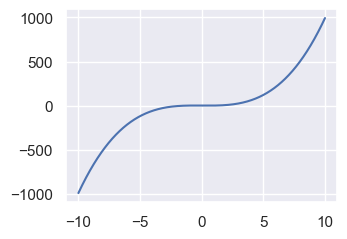

In [307]:
def f(x: torch.Tensor) -> torch.Tensor:
    return x ** 3 - x + 2


SIGN = -1  # 1 - max, -1 - min

START, END = -10, 10
EPS = 0.000001
LR = 0.001

X = torch.arange(START, END + 0.001, 0.001)
Y = f(X)
plt.plot(X.detach(), Y.detach());

3000it [00:00, 6885.22it/s] 


Найден локальный минимум: x=0.577632, f(x)=1.615100
Причина остановки: найден экстремум


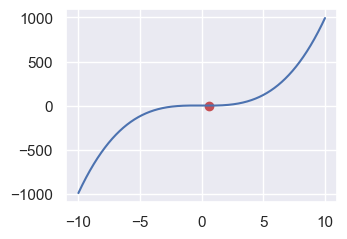

In [308]:
x, xs, reason = gradient_descent(func=f, interval=(START, END), sign=SIGN, eps=EPS, lr=LR, initial_state=9.1)
answer(x, SIGN, reason)

In [309]:
save_animation(xs, "optimization_3_1.gif")

100%|██████████| 621/621 [00:25<00:00, 24.08it/s]


![](optimization_3_1.gif)

1000it [00:00, 199301.69it/s]


Найден локальный минимум: x=-10.000000, f(x)=-988.000000
Причина остановки: выход за границы интервала


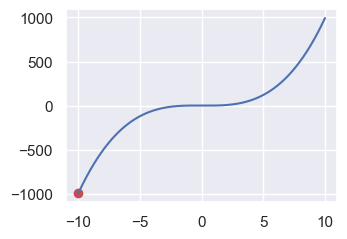

In [310]:
x, xs, reason = gradient_descent(func=f, interval=(START, END), sign=SIGN, eps=EPS, lr=LR, initial_state=-6)
answer(x, SIGN, reason)

In [311]:
save_animation(xs, "optimization_3_2.gif")

100%|██████████| 56/56 [00:02<00:00, 20.69it/s]


![](optimization_3_2.gif)